# Undersea Cables

Dataset: https://www.kaggle.com/datasets/sndorburian/underwater-marine-data-cables/data 

## 1. Exploratory Data Analysis

In [1]:
# Initial Data Load

import json
import pandas as pd
from shapely import MultiLineString
import kagglehub

path = kagglehub.dataset_download("sndorburian/underwater-marine-data-cables")
data = json.load(open("../data/kaggle/underwatercable.json"))
df_undersea = pd.DataFrame(data["features"])
df_undersea.head()

,type,properties,geometry
0,Feature,"{'id': 'carnival-submarine-network-1-csn-1', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
1,Feature,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","{'type': 'MultiLineString', 'coordinates': [[[..."
2,Feature,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","{'type': 'MultiLineString', 'coordinates': [[[..."
3,Feature,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
4,Feature,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","{'type': 'MultiLineString', 'coordinates': [[[..."


In [2]:
import geopandas as gpd

# Geo-enrichment of the data

gdf_undersea = df_undersea.copy(deep=False)

name_list = []
id_list = []
color_list = []

for i in df_undersea.index:
    name_i = df_undersea.loc[i].properties["name"]
    name_list.append(name_i)
    id_i = df_undersea.loc[i].properties["id"]
    id_list.append(id_i)
    color_i = df_undersea.loc[i].properties["color"]
    color_list.append(color_i)

gdf_undersea["id"] = id_list
gdf_undersea["name"] = name_list
gdf_undersea["color"] = color_list

geom_list = []
for i in df_undersea.index:
    geom_i = MultiLineString(pd.DataFrame(data["features"]).geometry.loc[i]["coordinates"])
    geom_list.append(geom_i)


gdf_undersea = gpd.GeoDataFrame(gdf_undersea, geometry = geom_list)
gdf_undersea = gdf_undersea.set_crs(4326)
gdf_undersea = gdf_undersea[["id", "name", "color", "properties", "geometry"]]
# gdf_undersea = gdf_undersea.drop_duplicates(subset=["id"]) # Drop duplicates - not yet
gdf_undersea.head()

,id,name,color,properties,geometry
0,carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487..."
1,sea-h2x,SEA-H2X,#939597,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999..."
2,hronn,Hronn,#009f94,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55...."
3,cook-strait,Cook Strait,#951f63,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431..."
4,minoas-east-and-west,Minoas East and West,#939597,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ..."


Additionally, we will also calculate the length of each cable, which will further serve as a proxy for the total **bandwith** of said cable when we program our quantum algorithm. Since we struggled finding fitting data specifying the bandwith of these cables, we decided upon a simple heuristic in which longer cables are expected to carry more bandwith. It is not bulletproof, we know, but it's the best we could come up with on the spot;)

In [3]:
gdf_undersea_measurement = gdf_undersea.copy(deep=False)
gdf_undersea_measurement = gdf_undersea_measurement.to_crs(3857)  # Set CRS to EPSG:3857 for measurement
gdf_undersea["bandwith"] = gdf_undersea_measurement["geometry"].apply(lambda x: x.length / 1000)  # Length in km
gdf_undersea.head()


,id,name,color,properties,geometry,bandwith
0,carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487...",4534.917302
1,sea-h2x,SEA-H2X,#939597,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999...",5366.804446
2,hronn,Hronn,#009f94,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55....",460.853735
3,cook-strait,Cook Strait,#951f63,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431...",44.928948
4,minoas-east-and-west,Minoas East and West,#939597,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ...",322.695477


Below, we plot the data using the freely available `natural_earth` geodataset (https://www.naturalearthdata.com/downloads/110m-cultural-vectors/)

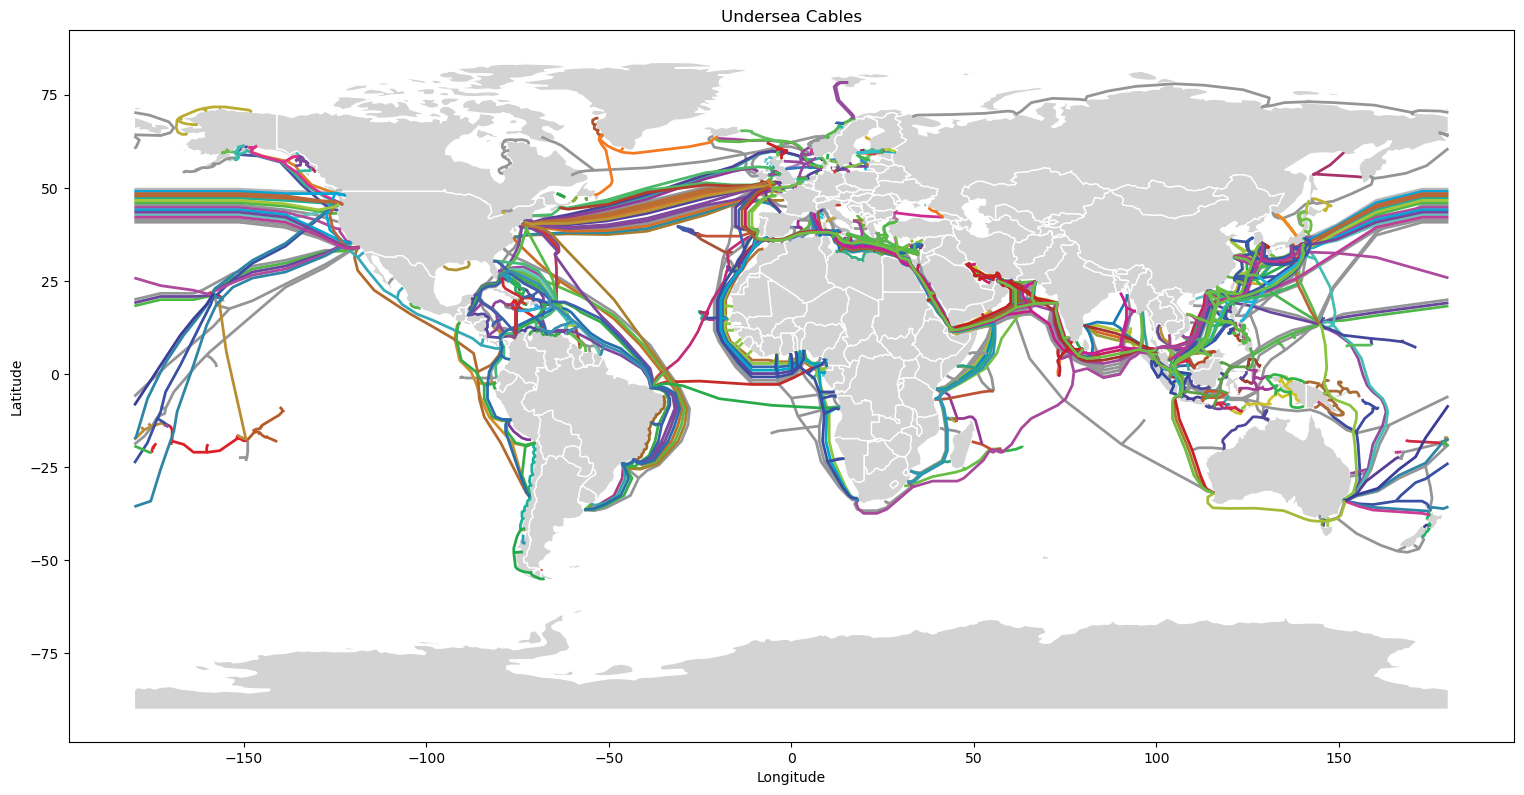

In [4]:
import matplotlib.pyplot as plt

# Download world shapefile for plotting
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")

fig, ax = plt.subplots(figsize=(16, 8))
world.plot(ax=ax, color='lightgray', edgecolor='white')

gdf_undersea.plot(ax=ax, color=gdf_undersea["color"], linewidth=2, legend=True)

plt.title("Undersea Cables")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.savefig("../undersea_cables_world.png", dpi=200) # Save to repo
plt.show()

If we zoom in, however, we find our first issue - the entries in the dataset are persisted using the `MultiLineString` format and therefore it can be problematic to try and represent them using standard measurements such as length or other statistics:

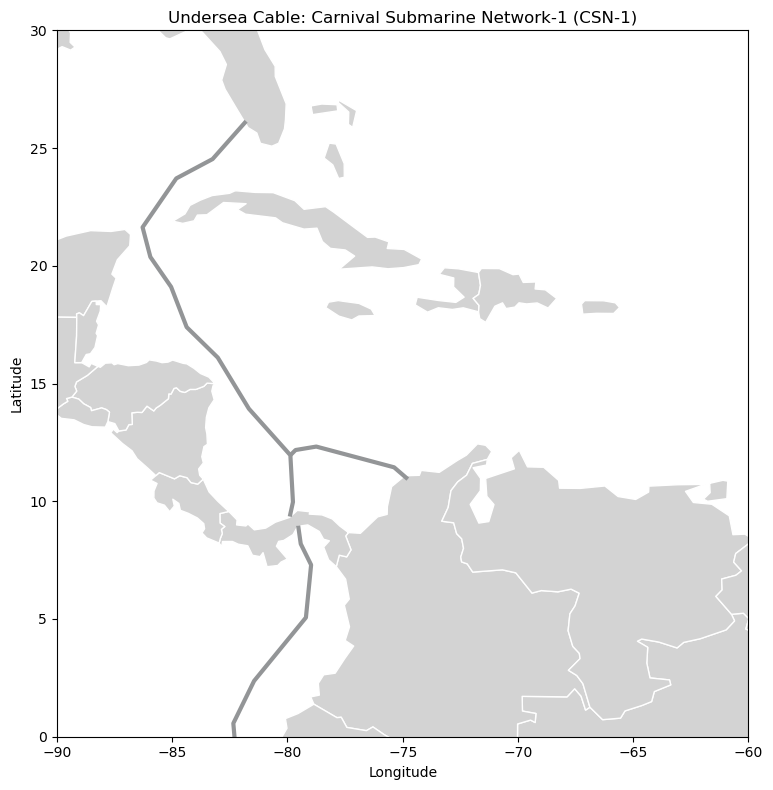

In [5]:
# Plot the first cable (Caribbean region)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot world basemap
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color='lightgray', edgecolor='white')

# Plot the first cable
gdf_undersea.iloc[0:1].plot(ax=ax, color=gdf_undersea.iloc[0]["color"], linewidth=3)

plt.title(f"Undersea Cable: {gdf_undersea.iloc[0]['name']}")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim(-90, -60)  # Adjust as needed for the Caribbean
plt.ylim(0, 30)
plt.tight_layout()
plt.show()

Additionally, we also look for duplicates in our dataset, realising that many of these are cables that are also Y-shaped and connect to each other. Therefore, we join them to ensure data consistency. Luckily, such cables only come in pairs.

After this, we also persist the `gdf_undersea` dataset for further analysis.

In [6]:
from shapely.geometry import MultiLineString

duplicate_ids = gdf_undersea[gdf_undersea.duplicated(subset=["id"], keep=False)]["id"].unique()
df_cables_doubled = gdf_undersea[gdf_undersea["id"].isin(duplicate_ids)].sort_values(by="id")

gdf_y = gpd.GeoDataFrame() # New DF

for i in duplicate_ids:
    df_x = df_cables_doubled[df_cables_doubled["id"] == i].copy() 
    if len(df_x) < 2:
        print(f"Skipping ID {i} due to insufficient entries.")
        continue
    joined_geoms = MultiLineString(list(df_x.geometry.iloc[0].geoms) + list(df_x.geometry.iloc[1].geoms))
    joined_bandwidth = df_x.bandwith.iloc[0] + df_x.bandwith.iloc[1]
    df_x = df_x.drop_duplicates(subset=["id"]).iloc[[0]]
    df_x["geometry"] = [joined_geoms] 
    df_x["bandwith"] = joined_bandwidth
    gdf_y = pd.concat([gdf_y, df_x], ignore_index=True)

# Add those entries back to the original GeoDataFrame
gdf_undersea = gdf_undersea[~gdf_undersea["id"].isin(duplicate_ids)]
gdf_undersea = pd.concat([gdf_undersea, gdf_y], ignore_index=True)
gdf_undersea.to_file("../data/gdf_undersea.geojson", driver="GeoJSON") # Persist file

gdf_y

,id,name,color,properties,geometry,bandwith
0,havfrueaec-2,Havfrue/AEC-2,#30aa9f,"{'id': 'havfrueaec-2', 'name': 'Havfrue/AEC-2'...","MULTILINESTRING ((7.99626 58.15107, 7.87507 57...",11541.848735
1,peace-cable,PEACE Cable,#0090c5,"{'id': 'peace-cable', 'name': 'PEACE Cable', '...","MULTILINESTRING ((37.91255 20.37504, 38.10005 ...",23281.918590
2,jupiter,JUPITER,#929497,"{'id': 'jupiter', 'name': 'JUPITER', 'color': ...","MULTILINESTRING ((141.97497 34.40502, 141.0749...",17425.560143
3,tannat,Tannat,#34a8a7,"{'id': 'tannat', 'name': 'Tannat', 'color': '#...","MULTILINESTRING ((-46.32806 -23.96184, -45.899...",2460.756682
4,globenet,GlobeNet,#7b489c,"{'id': 'globenet', 'name': 'GlobeNet', 'color'...","MULTILINESTRING ((-80.08893 26.35058, -79.6498...",23603.749361
5,pacific-light-cable-network-plcn,Pacific Light Cable Network (PLCN),#bc3e96,"{'id': 'pacific-light-cable-network-plcn', 'na...","MULTILINESTRING ((-118.41596 33.91992, -120.59...",15400.334950
6,pishgaman-oman-iran-poi-network,Pishgaman Oman Iran (POI) Network,#939597,"{'id': 'pishgaman-oman-iran-poi-network', 'nam...","MULTILINESTRING ((57.7973 25.68132, 57.95931 2...",632.059941


----

## 2. Graph Creation

In order to formulate our problem within the graph theory domain in order to run quantum algorithms on it, we need to do a number of operations:

1. Extract all points from each MultiLineString and represent each individual point as a node and the connection (`LineString`) between them as an edge to form the graph that will underpin our solution
2. For each node, however, we will also keep the `id` value of the undersea cable it belongs to as a foreign key relating it to the original master table of cables. 
3. We also keep the `start_node` and `end_node` of each edge.

In [7]:
from shapely.geometry import Point, LineString

nodes = []
edges = []

for idx, row in gdf_undersea.iterrows():
    geom = row.geometry
    cable_id = row.id
    # Handle both MultiLineString and LineString
    if geom.geom_type == "MultiLineString":
        lines = list(geom.geoms)
    elif geom.geom_type == "LineString":
        lines = [geom]
    else:
        continue

    for line in lines:
        coords = list(line.coords)
        # Add nodes
        for pt in coords:
            nodes.append({"cable_id": cable_id, "geometry": Point(pt)})
        # Add edges (between consecutive points)
        for i in range(len(coords) - 1):
            edge = LineString([coords[i], coords[i+1]])
            edges.append({"cable_id": cable_id, "geometry": edge})

# Remove duplicate nodes and assign unique node_id
gdf_nodes = gpd.GeoDataFrame(nodes).drop_duplicates(subset=["geometry"]).reset_index(drop=True)
gdf_nodes = gdf_nodes.set_crs(4326)
gdf_nodes["node_id"] = gdf_nodes.index

# Create a mapping from Point geometry to node_id
point_to_id = {pt.wkt: node_id for pt, node_id in zip(gdf_nodes.geometry, gdf_nodes.node_id)}

# Add start_node and end_node to the edge table
start_nodes = []
end_nodes = []

for line in edges:
    line_geom = line["geometry"]
    start_pt = Point(line_geom.coords[0])
    end_pt = Point(line_geom.coords[1])
    start_nodes.append(point_to_id[start_pt.wkt])
    end_nodes.append(point_to_id[end_pt.wkt])

gdf_edges = gpd.GeoDataFrame(edges)
gdf_edges = gdf_edges.set_crs(4326)
gdf_edges["start_node"] = start_nodes
gdf_edges["end_node"] = end_nodes

# Preview
print("Number of unique nodes:", gdf_nodes.shape[0], 
      "\nNumber of unique edges:", gdf_edges.shape[0])

Number of unique nodes: 9404 
Number of unique edges: 9747


Additionally, we also add the **bandwith** statistic from `gdf_undersea` and we calculate the length (**weight**) of every edge present in the dataset. We do this with the help of the EPSG 3857 metric representation.

In [8]:
# Add bandwith information to edges from undersea cables

gdf_edges = pd.merge(gdf_edges, gdf_undersea[["id", "bandwith"]], left_on="cable_id", right_on="id", how="left").drop("id", axis=1)

# Find the length of each undersea cable in kilometers

gdf_edge_measurement = gdf_edges.copy(deep=False)
gdf_edge_measurement = gdf_edge_measurement.to_crs(3857)  # Set CRS to EPSG:3857 for measurement
gdf_edge_measurement["weight"] = gdf_edge_measurement["geometry"].apply(lambda x: x.length / 1000)  # Length in km

# Add the length of each cable to the original GeoDataFrame
gdf_edges["weight"] = gdf_edge_measurement["weight"]

gdf_edges = gdf_edges.reset_index()
gdf_edges.columns = ["edge_id", "cable_id", "geometry", "start_node", "end_node", "bandwith", "weight"]
gdf_edges["edge_id"] = gdf_edges.edge_id.apply(lambda x: f"edge_{x:04d}")
gdf_edges["start_node"] = gdf_edges.start_node.apply(lambda x: f"node_{x:04d}")
gdf_edges["end_node"] = gdf_edges.end_node.apply(lambda x: f"node_{x:04d}")

gdf_edges.head()

,edge_id,cable_id,geometry,start_node,end_node,bandwith,weight
0,edge_0000,carnival-submarine-network-1-csn-1,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)",node_0000,node_0001,4534.917302,88.053051
1,edge_0001,carnival-submarine-network-1-csn-1,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)",node_0001,node_0002,4534.917302,112.012998
2,edge_0002,carnival-submarine-network-1-csn-1,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)",node_0002,node_0003,4534.917302,251.717905
3,edge_0003,carnival-submarine-network-1-csn-1,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)",node_0003,node_0004,4534.917302,391.244580
4,edge_0004,carnival-submarine-network-1-csn-1,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)",node_0004,node_0005,4534.917302,224.025995


In [9]:
gdf_nodes = gdf_nodes[["node_id", "cable_id", "geometry"]]
gdf_nodes["node_id"] = gdf_nodes.node_id.apply(lambda x: f"node_{x:04d}")

gdf_nodes.head()

,node_id,cable_id,geometry
0,node_0000,carnival-submarine-network-1-csn-1,POINT (-79.53671 8.96483)
1,node_0001,carnival-submarine-network-1-csn-1,POINT (-79.42487 8.19054)
2,node_0002,carnival-submarine-network-1-csn-1,POINT (-78.97487 7.29876)
3,node_0003,carnival-submarine-network-1-csn-1,POINT (-79.19987 5.06199)
4,node_0004,carnival-submarine-network-1-csn-1,POINT (-81.44987 2.36791)


However, we uncover another problem - some of the nodes are duplicated. Not in the orthodox sense of the word, however. They are duplicated geographically, in the sense that they are merely very close to each other. This poses a problem, as we need to be very careful to maintain edge functionality when removing said duplicate nodes. Below is an example of the city of Foraleza in Brazil, home to two incredibly close nodes:

In [10]:
gdf_nodes[(gdf_nodes["node_id"] == "node_3556") | (gdf_nodes["node_id"] == "node_3539")]

,node_id,cable_id,geometry
3539,node_3539,south-atlantic-inter-link-sail,POINT (-38.54297 -3.71874)
3556,node_3556,brusa,POINT (-38.54296 -3.71874)


We attempt to remove them and adjust the edges accordingly:

In [11]:
import numpy as np

# Set a threshold distance (e.g., 0.01 degrees)
threshold_distance = 0.01  # Distance threshold in degrees

# Calculate distance between nodes
node_coords = np.array([node.coords[0] for node in gdf_nodes.geometry])
node_ids = gdf_nodes['node_id'].values

# Function to check if two nodes are within the threshold distance
def are_nodes_close(node1, node2, threshold=threshold_distance):
    return node1.distance(node2) <= threshold

# Create a dictionary for node merging
merged_nodes = {}

# Loop through nodes to find close nodes and merge
for i, node1 in enumerate(gdf_nodes.geometry):
    for j, node2 in enumerate(gdf_nodes.geometry):
        if i < j and are_nodes_close(node1, node2):
            # Assign the same new merged node id to both nodes
            merged_nodes[node_ids[j]] = node_ids[i]

# Merge Nodes
    # Create the new merged node list based on merged_nodes mapping
merged_nodes_list = []

for node_id, row in gdf_nodes.iterrows():
    # Check if the node is part of the merge (i.e., if it has been merged)
    new_node_id = merged_nodes.get(row['node_id'], row['node_id'])  # If merged, use the new ID; else keep original ID
    
    # Add the merged node data (node_id and geometry) to the new node list
    merged_nodes_list.append({
        'node_id': new_node_id,
        'geometry': row['geometry']
    })

# Create a GeoDataFrame for the merged nodes
gdf_merged_nodes = gpd.GeoDataFrame(merged_nodes_list, crs=gdf_nodes.crs)

# Remove duplicates (in case multiple nodes merged into one)
gdf_merged_nodes = gdf_merged_nodes.drop_duplicates(subset=['node_id']).reset_index(drop=True)

# Update Edges Based on Merged Nodes
    # Function to update edges based on merged nodes
def update_edges_for_merged_nodes(edge, merged_nodes):
    start_node = edge['start_node']
    end_node = edge['end_node']

    # Update start and end node IDs based on the merged nodes mapping
    if start_node in merged_nodes:
        start_node = merged_nodes[start_node]
    if end_node in merged_nodes:
        end_node = merged_nodes[end_node]

    # Update edge geometry based on the new nodes
    start_point = gdf_merged_nodes[gdf_merged_nodes['node_id'] == start_node].geometry.iloc[0]
    end_point = gdf_merged_nodes[gdf_merged_nodes['node_id'] == end_node].geometry.iloc[0]
    
    updated_edge = LineString([start_point, end_point])
    
    return updated_edge, start_node, end_node

# Apply the update function to the edges
updated_edges = []

for idx, edge in gdf_edges.iterrows():
    updated_edge, start_node, end_node = update_edges_for_merged_nodes(edge, merged_nodes)
    updated_edges.append({
        'edge_id': edge['edge_id'],
        'start_node': start_node,
        'end_node': end_node,
        'geometry': updated_edge,
        'bandwith': edge['bandwith'], 
        'weight': edge['weight']
    })

# Convert the updated edges list back into a GeoDataFrame
gdf_updated_edges = gpd.GeoDataFrame(updated_edges, crs=gdf_edges.crs)

# Add back the cable_id to the updated edges
gdf_updated_edges = pd.merge(gdf_updated_edges, 
                             gdf_edges[["edge_id", "cable_id"]])[["edge_id", "cable_id", "geometry", "start_node", "end_node", "bandwith", "weight"]]

# Validate the Process
    # Final preview of merged nodes and updated edges
gdf_merged_nodes = pd.merge(gdf_merged_nodes, gdf_nodes, how="left") # Add back the cable_id
        # Note: The how="left" will make some 70 entries NaN, as they were not present in the original gdf_nodes.
gdf_merged_nodes.head()


,node_id,geometry,cable_id
0,node_0000,POINT (-79.53671 8.96483),carnival-submarine-network-1-csn-1
1,node_0001,POINT (-79.42487 8.19054),carnival-submarine-network-1-csn-1
2,node_0002,POINT (-78.97487 7.29876),carnival-submarine-network-1-csn-1
3,node_0003,POINT (-79.19987 5.06199),carnival-submarine-network-1-csn-1
4,node_0004,POINT (-81.44987 2.36791),carnival-submarine-network-1-csn-1


In [12]:
gdf_updated_edges.head()

,edge_id,cable_id,geometry,start_node,end_node,bandwith,weight
0,edge_0000,carnival-submarine-network-1-csn-1,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)",node_0000,node_0001,4534.917302,88.053051
1,edge_0001,carnival-submarine-network-1-csn-1,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)",node_0001,node_0002,4534.917302,112.012998
2,edge_0002,carnival-submarine-network-1-csn-1,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)",node_0002,node_0003,4534.917302,251.717905
3,edge_0003,carnival-submarine-network-1-csn-1,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)",node_0003,node_0004,4534.917302,391.244580
4,edge_0004,carnival-submarine-network-1-csn-1,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)",node_0004,node_0005,4534.917302,224.025995


In [13]:
# Persist data

# gdf_nodes.to_file("../data/gdf_nodes.geojson", driver="GeoJSON")
# gdf_edges.to_file("../data/gdf_edges.geojson", driver="GeoJSON")

gdf_merged_nodes.to_file("../data/gdf_nodes.geojson", driver="GeoJSON")
gdf_updated_edges.to_file("../data/gdf_edges.geojson", driver="GeoJSON")

Now, we are ready to represent our structure as a **graph**. We do this using the `networkx` library in Python.

In [14]:
import networkx as nx

# Create an undirected graph
G = nx.Graph()

# Add nodes with attributes 
for _, row in gdf_merged_nodes.iterrows():
    G.add_node(row["node_id"], cable_id=row["cable_id"], geometry=row["geometry"])

# Add edges using start_node and end_node
for _, row in gdf_updated_edges.iterrows():
    G.add_edge(row["start_node"], row["end_node"], cable_id=row["cable_id"], geometry=row["geometry"], edge_attr='weight')

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 9289 nodes and 9730 edges.


Now that we have such a graph, we can look at various statistics, such as querying the nodes with the highest degree centrality in the graph, i.e. most important nodes in the global undersea internet cable network.

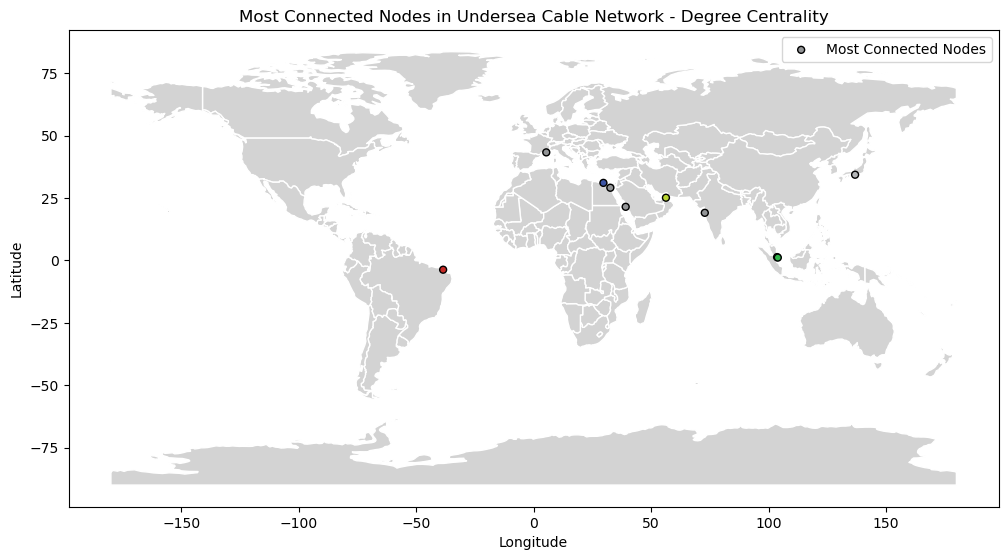

In [15]:
# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
degree_centrality_ordered = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in degree_centrality_ordered[0:top_n]]
degree_centrality = [x[1] for x in degree_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_merged_nodes[gdf_merged_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Degree Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


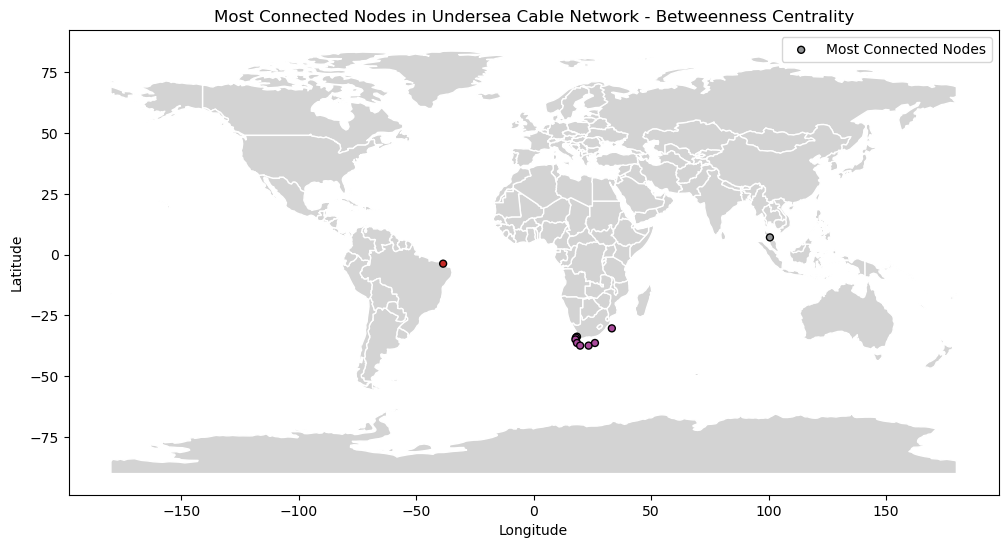

In [16]:
# Calculate betweenness centrality
betweenness_centrality = nx.betweenness_centrality(G)
betweenness_centrality_ordered = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)

top_n = 10
most_connected_nodes = [x[0] for x in betweenness_centrality_ordered[0:top_n]]
betweenness_centrality = [x[1] for x in betweenness_centrality_ordered[0:top_n]]

# Get the GeoDataFrame of the most connected nodes
top_nodes_gdf = gdf_merged_nodes[gdf_merged_nodes["node_id"].isin(most_connected_nodes)].copy()
# Merge with original gdf to get cable color

top_nodes_gdf = pd.merge(top_nodes_gdf, gdf_undersea[["id", "color"]], left_on="cable_id", right_on="id", how="left"
)[["node_id", "cable_id", "geometry", "color"]].head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

# Plot a world basemap (you might need to adjust the path)
world = gpd.read_file("../data/map_data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")
world.plot(ax=ax, color="lightgray", edgecolor="white")
top_nodes_gdf.plot(ax=ax, color=top_nodes_gdf.color, edgecolor="black", markersize=25, label="Most Connected Nodes")
ax.set_title("Most Connected Nodes in Undersea Cable Network - Betweenness Centrality")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()


----

## 3. Max Flow Optimization

Now that we have created our graph and concluded our initial analysis, we can stipulate the first of our optimization objectives: finding the maximum amount of flow that can be pushed from a *source node* to a *sink node* in this network, while adhering to a capacity contraint (in this case, the bandwith, which we have calculated based on the total length of the cable each node belongs to and represents, we repeat, an arbitrary number...) on the edges. We stipulate our problem as such:

Each edge (segment of a submarine cable) $(u,v) \in E$ has a capacity $c(u,v)$, i.e., the maximum amount of data that can pass from node $u$ to node $v$ and vice-versa through this edge.

The flow $f(u,v)$, therefore, can not be higher than the overall edge capacity $f(u,v) \leq c(u,v)$. The objective is to **maximise** the flow from source node $s$ to sink node $t$.



# Maximum Flow Problem: Classical Approach

### Problem Overview:
The **Maximum Flow Problem** aims to determine the maximum amount of flow that can be sent from a **source node** to a **sink node** in a **flow network**, respecting the capacity constraints on each edge.

### Graph Representation:
- **Vertices (V)**: Nodes in the graph (e.g., source, sink, intermediates).
- **Edges (E)**: Directed edges with associated **capacity** (maximum allowable flow).

### Constraints:
1. **Flow Conservation**: The total incoming flow to a node equals the total outgoing flow (for all nodes except source and sink).
2. **Capacity Constraints**: Flow on each edge cannot exceed its capacity.
3. **Max Flow Objective**: Maximize the total flow from the source to the sink.

### Classical Algorithms:
#### 1. **Ford-Fulkerson Algorithm**:
- **Process**:
  1. Initialize flow to 0 on all edges.
  2. Find an **augmenting path** (path from source to sink with residual capacity).
  3. Increase flow along the path (limited by the minimum capacity).
  4. Update residual capacities.
  5. Repeat until no augmenting paths are found.
  
- **Time Complexity**: \( O(f \cdot E) \), where \( f \) is the maximum flow and \( E \) is the number of edges. The worst-case scenario could involve finding many augmenting paths if the capacities are irrational.

#### 2. **Edmonds-Karp Algorithm**:
- **Process**: An implementation of the Ford-Fulkerson method using **Breadth-First Search (BFS)** to find the shortest augmenting path.
  
- **Time Complexity**: \( O(V \cdot E^2) \), where \( V \) is the number of vertices and \( E \) is the number of edges. It guarantees polynomial time and is generally more efficient than the original Ford-Fulkerson method.

#### 3. **Push-Relabel Algorithm**:
- **Process**: Uses node heights and pushes flow locally, optimizing the flow with fewer iterations.
  
- **Time Complexity**: Generally better than Ford-Fulkerson for dense graphs, with a complexity of \( O(V^2 E) \).

### Example: Simple Network

Consider the following simple directed graph with nodes \( V = \{ s, a, b, t \} \) and edges with capacities:

- \( s \to a \): capacity = 10
- \( s \to b \): capacity = 5
- \( a \to t \): capacity = 15
- \( b \to t \): capacity = 10
- \( a \to b \): capacity = 4


### Flow Calculation Steps:
1. Start with zero flow on all edges.
2. Find an augmenting path (e.g., \( s \to a \to t \)).
3. Push flow along this path (flow = 10 on edge \( s \to a \), 10 on edge \( a \to t \)).
4. Repeat with the residual network, finding paths like \( s \to b \to t \).
5. Continue until no more augmenting paths can be found.

### Max Flow Calculation:
Using the Ford-Fulkerson method, the maximum flow in this example is 15 units.

### Summary:
- The **Maximum Flow Problem** involves maximizing the flow from the source to the sink while adhering to edge capacities.
- The classical approach uses algorithms like **Ford-Fulkerson**, **Edmonds-Karp**, and **Push-Relabel** to find the maximum flow.
- The solution relies on iteratively finding augmenting paths and updating residual capacities until no further paths are available.

